# Gesture Recognition

**Sreenath S, Chirag N S**

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

NOTE: Though we set the random variable it is observed that there are considerable difference in trained models over the time

In [2]:
import random as rn
from keras import backend as K
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)

Using TensorFlow backend.


**BATCH SIZE ANALYSIS**

During the batch size analysis it is found that max up to 35-40 batches (with queue size defaulted to 10) it is allowing beyond that getting memory exhaustion error. Hence using Batch Size of 20, since we may need to try augmentation down the line.

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 20

print("Training data length: ", len(train_doc))
print("Validation data length: ", len(val_doc))

Training data length:  663
Validation data length:  100


**FUNCTION TO PERFORM AUGMENTATION**

Function to augment the data. We are only considering rotationa and translation. 

Rotation in the range of 15 degrees and both vertical and horizontal shift 10% of the actual size.

In [4]:
def get_augmented_image(image):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.10,
        height_shift_range=0.10)
    augmented_image = datagen.random_transform(image)
    return augmented_image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.


Generator is updated to take follwoing parameters:
1. batch size - Size of the mini batches
2. frames per video - Numeber of frames to be considered per video
3. height - Resize dimension - height
4. width - Resize dimension - width
5. apply_augmentation - Boolean to indicate whether to apply augmentation or not.
 

In [5]:
def generator(source_path, 
              folder_list, 
              batch_size, 
              frame_per_video= 30, 
              height = 120, width = 120, 
              apply_augmentation = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    x = frame_per_video
    y = height
    z = width
    # Create a list of image numbers you want to use for a particular video
    # If the frame_per_video == 30, then consider all 30 images per video.
    # If the frame per video is other than 30, then consider the images from the middle of the video, 
    # As per the visual analysis done on a random set of videos, the images from the beginning and end does not convey
    # much details. Most of the gesture movements are on the middle part of the video.
    if(x == 30):
        img_idx = range(x)
    else:
        start = (30-x)//2
        img_idx = range(start, start+x)
        print(img_idx)
    batch_counter = 0
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size        # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_counter = batch
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            if apply_augmentation:
                batch_data_augmented = np.zeros((batch_size,x,y,z,3))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    im_resize=imresize(image,(y,z,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = im_resize[:,:,0]/255   #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = im_resize[:,:,1]/255   #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = im_resize[:,:,2]/255   #normalise and feed in the image
                    
                    if apply_augmentation:
                        augmented_img = get_augmented_image(im_resize)
                        batch_data_augmented[folder,idx,:,:,0] = augmented_img[:,:,0]/255   #normalise and feed in the image
                        batch_data_augmented[folder,idx,:,:,1] = augmented_img[:,:,1]/255   #normalise and feed in the image
                        batch_data_augmented[folder,idx,:,:,2] = augmented_img[:,:,2]/255   #normalise and feed in the image                        
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            if apply_augmentation:
                batch_data=np.concatenate([batch_data,batch_data_augmented])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # If the total number of videos are not completely divisible by batch_size, then that indicates
        # we need to hable the left over images after creating full batches. 
        delta = len(t)%batch_size
        if(delta > 0):
            batch = batch_counter+1
            batch_data = np.zeros((delta,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((delta,5)) # batch_labels is the one hot representation of the output
            if apply_augmentation:
                batch_data_augmented = np.zeros((delta,x,y,z,3))
            for folder in range(delta): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    im_resize=imresize(image,(y,z,3))

                    #Normalize the images-  Since it is RGB image we are going ahead with normalization using max intensity
                    batch_data[folder,idx,:,:,0] = im_resize[:,:,0]/255   #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = im_resize[:,:,1]/255   #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = im_resize[:,:,2]/255   #normalise and feed in the image
                    
                    if apply_augmentation:
                        augmented_img = get_augmented_image(im_resize)
                        batch_data_augmented[folder,idx,:,:,0] = augmented_img[:,:,0]/255   #normalise and feed in the image
                        batch_data_augmented[folder,idx,:,:,1] = augmented_img[:,:,1]/255   #normalise and feed in the image
                        batch_data_augmented[folder,idx,:,:,2] = augmented_img[:,:,2]/255   #normalise and feed in the image 

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if apply_augmentation:
                batch_data=np.concatenate([batch_data,batch_data_augmented])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels

**TESTING GENERATOR**

Let us now test the generator, we will using default batch size but will pass 85 test videos. Expected 4 full batches and 5th batch should have only 5 elements.

In [6]:
val_path = 'Project_data/val'
val_generator = generator(val_path, val_doc[:85], batch_size)
i = 0
for data in val_generator:
    print("Len:", len(data[0]))
    i = i+1
    if i >= 5:
        break

Source path =  Project_data/val ; batch size = 20
Len: 20
Len: 20
Len: 20
Len: 20
Len: 5


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
steps_per_epoch = 0
validation_steps = 0

# training sequences = 663
# validation sequences = 100
# epochs = 20


**CREATING THE CALLBACKS FOR MODEL CHECKPOINT AND REDUCE LR**

In [10]:
def create_call_backs(save_best_only = False, patience= 3, monitor = 'val_loss'):
    curr_dt_time = datetime.datetime.now()
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor = monitor, verbose=1, save_best_only=save_best_only, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor=monitor, factor=0.5, verbose=1, patience=patience)
    callbacks_list = [checkpoint, LR]
    
    return callbacks_list

**COMPUTE AND SET STEPS PER TRAINING AND VALIDATION EPOCH**

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
def set_steps_per_epoch(batchsize = 20):
    global batch_size;
    global steps_per_epoch;
    global validation_steps;
    global num_train_sequences;
    global num_val_sequences;
    batch_size = batchsize
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    print("Steps per epoch: {} and validation steps: {} ".format(steps_per_epoch, validation_steps))

In [12]:
def plot_training_details(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    ax[0].plot(history.history['loss'])   
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title("Loss- Train vs Val")
    ax[0].legend(['train_loss','val_loss'])

    ax[1].plot([x*100 for x in history.history['categorical_accuracy']])   
    ax[1].plot([x*100 for x in history.history['val_categorical_accuracy']])
    ax[1].set_title("Accuracy- Train vs Val")
    ax[1].legend(['train_accuracy','val_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### MODEL 1: 3D CONV WITH DROP OUT ONLY ON FC LAYER

In this model we are using all frames/video and given a filter size of (2, 2, 2) to extract finer details. Also drop-out is used only on FC layers. This willl be used as a starting network.

We are considering all the images per video for the analysis,

In [11]:
def create_initial_model():
    kernal_size=(2,2,2)
    dropout = 0.3
    num_sample = 30
    image_height = 120
    image_width = 120
    channels = 3

    model = Sequential()
    model.add(Conv3D(32, kernal_size, padding='same',
             input_shape=(num_sample,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, kernal_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernal_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(256, kernal_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))
    
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

We will be using adam as it will be internally adjusting the momentum and learning rate. We are using default learning rate(0.001) and beta params for adam. 

In [12]:
model1 = create_initial_model()
optimiser = optimizers.Adam()
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 32)  800       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 64)    16448     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 64)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 64)    256       
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
set_steps_per_epoch()
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
callbacks_list = create_call_backs()

Steps per epoch: 34 and validation steps: 5 


In [14]:
print(steps_per_epoch, validation_steps, callbacks_list)

34 5 [<keras.callbacks.ModelCheckpoint object at 0x7f0cc01b10f0>, <keras.callbacks.ReduceLROnPlateau object at 0x7f0cbc5f6c50>]


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 199s 6s/step - loss: 1.6734 - categorical_accuracy: 0.3775 - val_loss: 1.3081 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-09-1104_55_36.085475/model-00001-1.66820-0.37858-1.30809-0.54000.h5
Epoch 2/20
34/34 [==============================] - 88s 3s/step - loss: 1.2416 - categorical_accuracy: 0.5357 - val_loss: 1.1020 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-09-1104_55_36.085475/model-00002-1.24152-0.53243-1.10204-0.57000.h5
Epoch 3/20
34/34 [==============================] - 94s 3s/step - loss: 0.9448 - categorical_accuracy: 0.6468 - val_loss: 0.8902 - val_categorical_accuracy: 0.6700

Epoch 00003: saving model to model_init_2020-09-1104_55_36.085475/model-00003-0.91009-0.65460-0.89015-0.67000.h5
Epoch 4/20
34/34 [==============================] - 77s 2s/step

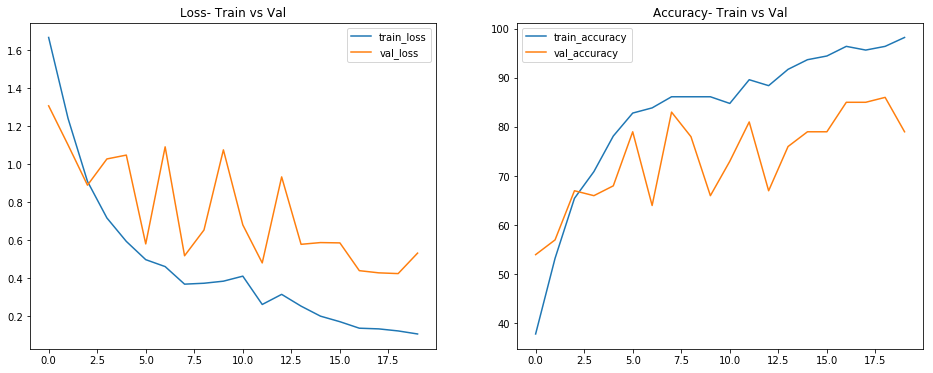

In [16]:
plot_training_details(history)

Here we can onserve that model is able to learn as epoch goes on. The model is not overfitting to a large extend.

### MODEL2: REDUCED COMPLEXITY BY  REDUCING NUMBER OF FILTERS AT LAST 3D CONV LAYER

As per above training we can observe that model is able to learn and it is not overfitting. We can now try to reduce the model complexity by:

1. Reduce the filters at last 3D layer from 256 to 128.
2. Will be considering only 24 frames per video for training purpose.

Also we can observe there are some oscillation in previous training, this can cause in case of large learning rate. Since oscillations are not too much and model is able to generalise, will try to reduce learning rate slightly from 0.001 to 0.0008

In [17]:
def create_model2():
    kernal_size=(2,2,2)
    dropout = 0.3
    num_sample = 24
    image_height = 120
    image_width = 120
    channels = 3

    model = Sequential()
    model.add(Conv3D(32, kernal_size, padding='same',
             input_shape=(num_sample,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 2, 2)))

    model.add(Conv3D(64, kernal_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernal_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernal_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))
    
    return model

In [18]:
model2 = create_model2()
optimiser = optimizers.Adam(lr=0.0008) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 24, 120, 120, 32)  800       
_________________________________________________________________
activation_5 (Activation)    (None, 24, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 60, 60, 64)     16448     
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 64)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 60, 60, 64)     256       
__________

In [19]:
batch_size = 20
set_steps_per_epoch(batch_size)
train_generator2 = generator(train_path, train_doc, batch_size, 24, 120, 120)
val_generator2 = generator(val_path, val_doc, batch_size, 24, 120, 120)
callbacks_list = create_call_backs()

Steps per epoch: 34 and validation steps: 5 


In [20]:
history = model2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 20
range(3, 27)
 Project_data/val ; batch size = 20
range(3, 27)
Epoch 1/20
34/34 [==============================] - 67s 2s/step - loss: 1.5208 - categorical_accuracy: 0.4047 - val_loss: 1.5734 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-09-1105_23_22.233395/model-00001-1.54260-0.39819-1.57344-0.51000.h5
Epoch 2/20
34/34 [==============================] - 58s 2s/step - loss: 1.1675 - categorical_accuracy: 0.5541 - val_loss: 0.8948 - val_categorical_accuracy: 0.7100

Epoch 00002: saving model to model_init_2020-09-1105_23_22.233395/model-00002-1.16091-0.55958-0.89477-0.71000.h5
Epoch 3/20
34/34 [==============================] - 59s 2s/step - loss: 0.8653 - categorical_accuracy: 0.6600 - val_loss: 0.8127 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-09-1105_23_22.233395/model-00003-0.88339-0.65158-0.81271-0.69000.h5
Epoch 4/20
34/34 [====================

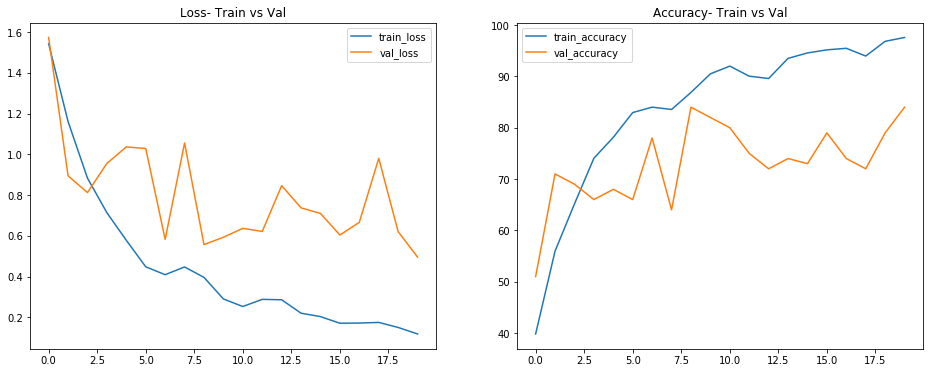

In [21]:
plot_training_details(history)

### MODEL 2A - WITH AUGMENTATION

As we can see above model is slightly overfitting. One way to avoid overfitting is to perform augmentation.We will retain the architecture same as Model 3 but this time we will apply augmentation.

In [22]:
model2a = create_model2()
optimiser = optimizers.Adam(lr=0.0008) #write your optimizer
model2a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 24, 120, 120, 32)  800       
_________________________________________________________________
activation_9 (Activation)    (None, 24, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 32)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 60, 60, 64)     16448     
_________________________________________________________________
activation_10 (Activation)   (None, 8, 60, 60, 64)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 60, 60, 64)     256       
__________

In [23]:
batch_size = 16
set_steps_per_epoch(batch_size)
train_generator2a = generator(train_path, train_doc, batch_size, 24, 120, 120, True)
val_generator2a = generator(val_path, val_doc, batch_size, 24, 120, 120)
callbacks_list = create_call_backs()

history = model2a.fit_generator(train_generator2a, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator2a, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Steps per epoch: 42 and validation steps: 7 
Source path =  Project_data/val ; batch size = 16
range(3, 27)
Source path =  Project_data/train ; batch size = 16
range(3, 27)
Epoch 1/20
42/42 [==============================] - 128s 3s/step - loss: 1.6704 - categorical_accuracy: 0.3846 - val_loss: 1.0519 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-09-1105_43_19.362029/model-00001-1.67823-0.38311-1.05190-0.54000.h5
Epoch 2/20
42/42 [==============================] - 116s 3s/step - loss: 1.1516 - categorical_accuracy: 0.5447 - val_loss: 1.0111 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2020-09-1105_43_19.362029/model-00002-1.15009-0.54525-1.01105-0.63000.h5
Epoch 3/20
42/42 [==============================] - 117s 3s/step - loss: 0.9508 - categorical_accuracy: 0.6329 - val_loss: 0.7592 - val_categorical_accuracy: 0.7200

Epoch 00003: saving model to model_init_2020-09-1105_43_19.362029/model-00003-0.95200-0.63273-0.75915-0

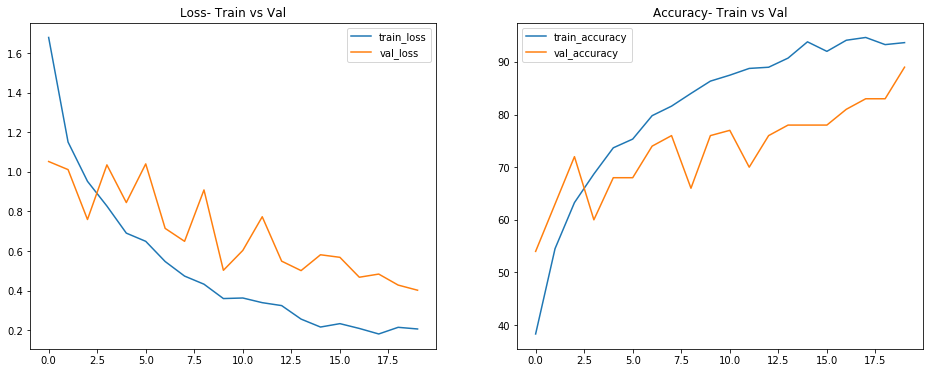

In [24]:
plot_training_details(history)

### MODEL 3: FURTHER REDUCING THE MODEL COMPLEXITY BY REMOVING LAST CONVOLUTION AND FC LAYERS

With above model having reduced filters at convolution layer also able to perform well on the dataset. Model is not overfitting. Hence, in next model we will further try to simplify this model by:
1. removing last conv3d layer.
2. removing last FC layer

But we will only use Drop out of 20%. 

In [25]:
def create_model3():
    kernal_size=(2,2,2)
    dropout = 0.2
    num_sample = 24
    image_height = 120
    image_width = 120
    channels = 3

    model = Sequential()
    model.add(Conv3D(32, kernal_size, padding='same',
             input_shape=(num_sample,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 2, 2)))

    model.add(Conv3D(64, kernal_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernal_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))
    
    return model

In [26]:
model3 = create_model3()
optimiser = optimizers.Adam(lr=0.0008) #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 24, 120, 120, 32)  800       
_________________________________________________________________
activation_13 (Activation)   (None, 24, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 24, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 60, 60, 64)     16448     
_________________________________________________________________
activation_14 (Activation)   (None, 8, 60, 60, 64)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 60, 60, 64)     256       
__________

In [27]:
batch_size = 20
set_steps_per_epoch(batch_size)
train_generator3 = generator(train_path, train_doc, batch_size, 24, 120, 120)
val_generator3 = generator(val_path, val_doc, batch_size, 24, 120, 120)
callbacks_list = create_call_backs()

history = model3.fit_generator(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Steps per epoch: 34 and validation steps: 5 
Source path =  Project_data/val ; batch size = 20
range(3, 27)
Source path =  Project_data/train ; batch size = 20
range(3, 27)
Epoch 1/20
34/34 [==============================] - 63s 2s/step - loss: 1.2173 - categorical_accuracy: 0.5077 - val_loss: 2.1255 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2020-09-1106_22_44.467907/model-00001-1.21681-0.50377-2.12550-0.38000.h5
Epoch 2/20
34/34 [==============================] - 57s 2s/step - loss: 0.6441 - categorical_accuracy: 0.7719 - val_loss: 0.6813 - val_categorical_accuracy: 0.7200

Epoch 00002: saving model to model_init_2020-09-1106_22_44.467907/model-00002-0.62323-0.78281-0.68127-0.72000.h5
Epoch 3/20
34/34 [==============================] - 58s 2s/step - loss: 0.4201 - categorical_accuracy: 0.8521 - val_loss: 0.6492 - val_categorical_accuracy: 0.7600

Epoch 00003: saving model to model_init_2020-09-1106_22_44.467907/model-00003-0.41629-0.85671-0.64923-0.76

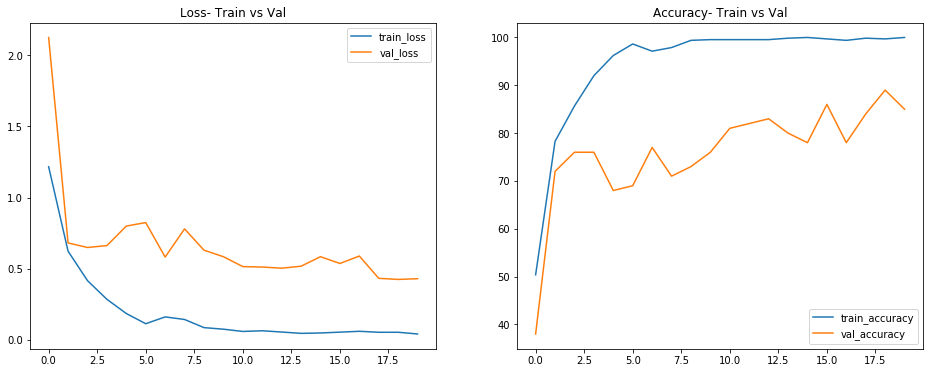

In [28]:
plot_training_details(history)

### MODEL 3A - WITH AUGMENTATION

As we can see above model is overfitting. One way to avoid overfitting is to perform augmentation.We will retain the architecture same as Model 3 but this time we will apply augmentation.

In [29]:
model3a = create_model3()
optimiser = optimizers.Adam(lr=0.0008) #write your optimizer
model3a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 24, 120, 120, 32)  800       
_________________________________________________________________
activation_16 (Activation)   (None, 24, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 24, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 32)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 8, 60, 60, 64)     16448     
_________________________________________________________________
activation_17 (Activation)   (None, 8, 60, 60, 64)     0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 8, 60, 60, 64)     256       
__________

In [30]:
batch_size = 16
set_steps_per_epoch(batch_size)
train_generator3a = generator(train_path, train_doc, batch_size, 24, 120, 120, True)
val_generator3a = generator(val_path, val_doc, batch_size, 24, 120, 120)
callbacks_list = create_call_backs()

history = model3a.fit_generator(train_generator3a, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3a, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Steps per epoch: 42 and validation steps: 7 
Source path =  Project_data/val ; batch size = 16
range(3, 27)
Source path =  Project_data/train ; batch size = 16
range(3, 27)
Epoch 1/15
42/42 [==============================] - 122s 3s/step - loss: 1.2975 - categorical_accuracy: 0.4870 - val_loss: 0.9318 - val_categorical_accuracy: 0.6300

Epoch 00001: saving model to model_init_2020-09-1106_42_22.034930/model-00001-1.29673-0.48492-0.93177-0.63000.h5
Epoch 2/15
42/42 [==============================] - 115s 3s/step - loss: 0.8715 - categorical_accuracy: 0.6619 - val_loss: 0.8037 - val_categorical_accuracy: 0.6700

Epoch 00002: saving model to model_init_2020-09-1106_42_22.034930/model-00002-0.87213-0.66214-0.80370-0.67000.h5
Epoch 3/15
42/42 [==============================] - 116s 3s/step - loss: 0.6757 - categorical_accuracy: 0.7549 - val_loss: 0.8842 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-09-1106_42_22.034930/model-00003-0.67316-0.75641-0.88421-0

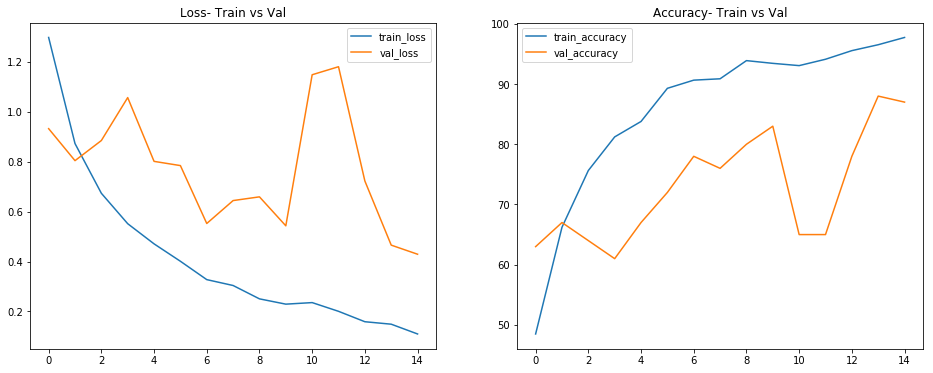

In [31]:
plot_training_details(history)

### MODEL 4: CNN- LSTM

A popular way to address sequential data such as video is to have a CNN model followed by an RNN model such as LSTM or GRU. Now we will try an architecture consisting of CNN-RNN. We will be using LSTM as part of this model. 

In [13]:
def create_model4():
    dropout = 0.3
    num_sample = 24
    image_height = 128
    image_width = 128
    channels = 3
    model4 = Sequential()

    model4.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
                              input_shape= (num_sample,image_height,image_width,channels)))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))

    model4.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))

    model4.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))

    model4.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))

    model4.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))
    model4.add(TimeDistributed(Flatten()))
    model4.add(Dropout(dropout))

    model4.add(LSTM(64))
    model4.add(Dropout(dropout))

    model4.add(Dense(64,activation='relu'))
    model4.add(Dropout(dropout))

    model4.add(Dense(5, activation='softmax'))
    return model4

In [14]:
model4 = create_model4()
optimiser = optimizers.Adam() #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 24, 128, 128, 16)  208       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 128, 128, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 64, 64, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 24, 64, 64, 32)    2080      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 24, 64, 64, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 24, 32, 32, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 24, 32, 32, 64)    8256      
__________

In [15]:
batch_size = 20
set_steps_per_epoch(batch_size)
train_generator4 = generator(train_path, train_doc, batch_size, 24, 128, 128)
val_generator4 = generator(val_path, val_doc, batch_size, 24, 128, 128)
callbacks_list = create_call_backs()

history = model4.fit_generator(train_generator4, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator4, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Steps per epoch: 34 and validation steps: 5 
Source path =  Project_data/val ; batch size = 20
range(3, 27)
Source path = Epoch 1/30
 Project_data/train ; batch size = 20
range(3, 27)
34/34 [==============================] - 182s 5s/step - loss: 1.5877 - categorical_accuracy: 0.2472 - val_loss: 1.4793 - val_categorical_accuracy: 0.3100

Epoch 00001: saving model to model_init_2020-09-1211_07_35.322138/model-00001-1.59361-0.25339-1.47926-0.31000.h5
Epoch 2/30
34/34 [==============================] - 64s 2s/step - loss: 1.4657 - categorical_accuracy: 0.3628 - val_loss: 1.3444 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-09-1211_07_35.322138/model-00002-1.47785-0.34691-1.34439-0.44000.h5
Epoch 3/30
34/34 [==============================] - 63s 2s/step - loss: 1.3159 - categorical_accuracy: 0.4437 - val_loss: 1.2221 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-09-1211_07_35.322138/model-00003-1.31652-0.44646-1.22213-0.5

### MODEL 5: CNN-GRU

As we can see above the LSTM model is doing prettywell on the training but not that good on validation data. Let us now try to reduce the number of parameters by replacing LSTM layer with GRU.

In [18]:
def create_model5():
    dropout = 0.3
    num_sample = 24
    image_height = 128
    image_width = 128
    channels = 3
    model5 = Sequential()

    model5.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
                              input_shape= (num_sample,image_height,image_width,channels)))
    model5.add(TimeDistributed(BatchNormalization()))
    model5.add(TimeDistributed(MaxPooling2D((2, 2))))

    model5.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
    model5.add(TimeDistributed(BatchNormalization()))
    model5.add(TimeDistributed(MaxPooling2D((2, 2))))

    model5.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
    model5.add(TimeDistributed(BatchNormalization()))
    model5.add(TimeDistributed(MaxPooling2D((2, 2))))

    model5.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
    model5.add(TimeDistributed(BatchNormalization()))
    model5.add(TimeDistributed(MaxPooling2D((2, 2))))

    model5.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
    model5.add(TimeDistributed(BatchNormalization()))
    model5.add(TimeDistributed(MaxPooling2D((2, 2))))
    model5.add(TimeDistributed(Flatten()))
    model5.add(Dropout(dropout))

    model5.add(GRU(64))
    model5.add(Dropout(dropout))

    model5.add(Dense(64,activation='relu'))
    model5.add(Dropout(dropout))

    model5.add(Dense(5, activation='softmax'))
    return model5

In [20]:
model5 = create_model5()
optimiser = optimizers.Adam(lr=0.0008) #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 24, 128, 128, 16)  208       
_________________________________________________________________
time_distributed_34 (TimeDis (None, 24, 128, 128, 16)  64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 24, 64, 64, 16)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 24, 64, 64, 32)    2080      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 24, 64, 64, 32)    128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 24, 32, 32, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 24, 32, 32, 64)    8256      
__________

In [21]:
batch_size = 20
set_steps_per_epoch(batch_size)
train_generator5 = generator(train_path, train_doc, batch_size, 24, 128, 128)
val_generator5 = generator(val_path, val_doc, batch_size, 24, 128, 128)
callbacks_list = create_call_backs()


history = model5.fit_generator(train_generator5, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator5, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Steps per epoch: 34 and validation steps: 5 
Source path =  Source path =  Project_data/val ; batch size = 20
range(3, 27)
Project_data/train ; batch size = 20
range(3, 27)
Epoch 1/30
34/34 [==============================] - 66s 2s/step - loss: 1.6042 - categorical_accuracy: 0.2936 - val_loss: 1.3427 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-09-1211_42_33.708359/model-00001-1.61607-0.29261-1.34265-0.46000.h5
Epoch 2/30
34/34 [==============================] - 61s 2s/step - loss: 1.3871 - categorical_accuracy: 0.4106 - val_loss: 1.2641 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-09-1211_42_33.708359/model-00002-1.36573-0.42081-1.26412-0.52000.h5
Epoch 3/30
34/34 [==============================] - 62s 2s/step - loss: 1.2396 - categorical_accuracy: 0.5004 - val_loss: 1.1630 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-09-1211_42_33.708359/model-00003-1.23541-0.49623-1.16303-0.51

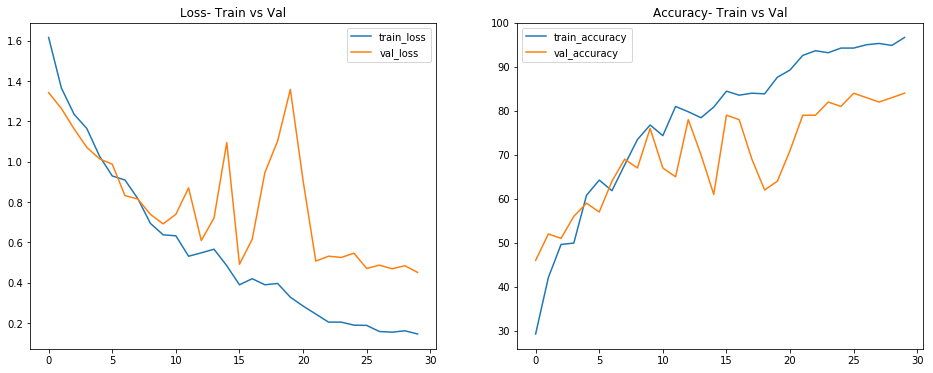

In [23]:
plot_training_details(history)

### MODEL 6: CNN-GRU MODEL WITH REDUCED MODEL COMPLEXITY

Here we will further reduce model complexity and number of parameters by reducing the filters at the CNN layer. We will be retaining RNN layers as such.

In [40]:
def create_model6():
    dropout = 0.3
    num_sample = 24
    image_height = 128
    image_width = 128
    channels = 3
    model6 = Sequential()

    model6.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
                              input_shape= (num_sample,image_height,image_width,channels)))
    model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D((2, 2))))

    model6.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
    model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D((2, 2))))

    model6.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
    model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D((2, 2))))

    model6.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
    model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D((2, 2))))

    model6.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
    model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D((2, 2))))
    model6.add(TimeDistributed(Flatten()))
    model6.add(Dropout(dropout))

    model6.add(GRU(64))
    model6.add(Dropout(dropout))

    model6.add(Dense(64,activation='relu'))
    model6.add(Dropout(dropout))

    model6.add(Dense(5, activation='softmax'))
    return model6

In [41]:
model6 = create_model6()
optimiser = optimizers.Adam(lr=0.0008) #write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_35 (TimeDis (None, 24, 128, 128, 16)  208       
_________________________________________________________________
time_distributed_36 (TimeDis (None, 24, 128, 128, 16)  64        
_________________________________________________________________
time_distributed_37 (TimeDis (None, 24, 64, 64, 16)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 24, 64, 64, 32)    2080      
_________________________________________________________________
time_distributed_39 (TimeDis (None, 24, 64, 64, 32)    128       
_________________________________________________________________
time_distributed_40 (TimeDis (None, 24, 32, 32, 32)    0         
_________________________________________________________________
time_distributed_41 (TimeDis (None, 24, 32, 32, 64)    8256      
__________

In [42]:
batch_size = 20
set_steps_per_epoch(batch_size)
train_generator6 = generator(train_path, train_doc, batch_size, 24, 128, 128)
val_generator6 = generator(val_path, val_doc, batch_size, 24, 128, 128)
callbacks_list = create_call_backs()


history = model6.fit_generator(train_generator6, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator6, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Steps per epoch: 34 and validation steps: 5 
Source path =  Project_data/val ; batch size = 20
range(3, 27)
Source path =  Project_data/train ; batch size = 20
range(3, 27)
Epoch 1/20
34/34 [==============================] - 67s 2s/step - loss: 1.6641 - categorical_accuracy: 0.2818 - val_loss: 1.3975 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-09-1108_13_22.919867/model-00001-1.66069-0.28054-1.39749-0.44000.h5
Epoch 2/20
34/34 [==============================] - 57s 2s/step - loss: 1.3714 - categorical_accuracy: 0.3966 - val_loss: 1.2147 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-09-1108_13_22.919867/model-00002-1.36814-0.39819-1.21468-0.53000.h5
Epoch 3/20
34/34 [==============================] - 61s 2s/step - loss: 1.2403 - categorical_accuracy: 0.4717 - val_loss: 1.0934 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-09-1108_13_22.919867/model-00003-1.24012-0.47511-1.09344-0.57

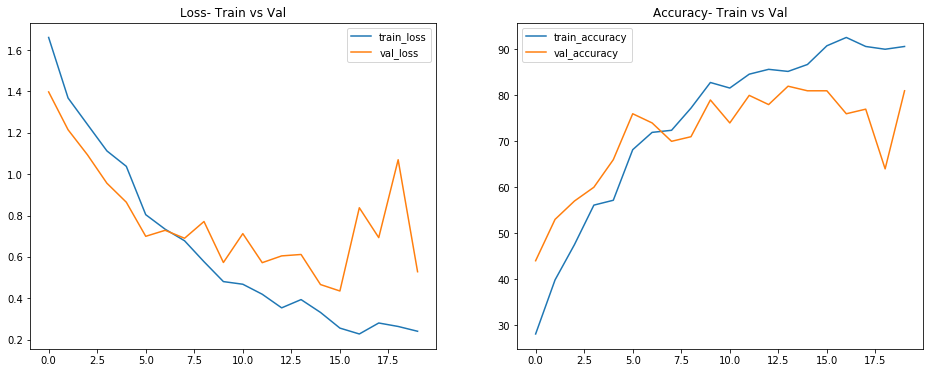

In [43]:
plot_training_details(history)

### TRANSFER LEARNING USING MOBILENET: 

Now we will be trying transfer learning by using pre trained models. But most of the pretrained models are bulky hence it might not be a good choice for this problem as we need to keep the memory footprint as low as possible. Hence we have analysed the paper https://arxiv.org/pdf/1810.00736.pdf and found that MobileNet will be a good fit interms od foot print, complexity and accuracy. Hence we will be using mobilenet for transfer learning.

**MODEL 7: MOBILENET WITH PARANS AS NON TRAINABLE**

We have gone through https://keras.io/api/applications/mobilenet/, https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299 and https://analyticsindiamag.com/a-practical-guide-to-implement-transfer-learning-in-tensorflow/ to understand how to reuse mobile net

In [11]:
from keras.applications import MobileNet

In [12]:
def create_model7():
    dropout = 0.3
    num_sample = 24
    image_height = 128
    image_width = 128
    channels = 3

    base_model=MobileNet(weights='imagenet',include_top=False, input_shape=(image_height, image_width, channels))
    for layer in base_model.layers:
        layer.trainable = False

    model7 = Sequential()
    model7.add(TimeDistributed(base_model, input_shape= (num_sample, image_height, image_width, channels)))
    model7.add(TimeDistributed(BatchNormalization()))
    model7.add(TimeDistributed(MaxPooling2D((2, 2))))
    model7.add(TimeDistributed(Flatten()))
    model7.add(Dropout(dropout))

    model7.add(GRU(64))
    model7.add(Dropout(dropout))

    model7.add(Dense(64,activation='relu'))
    model7.add(Dropout(dropout))

    model7.add(Dense(5, activation='softmax'))
    return model7

In [13]:
model7 = create_model7()
optimiser = optimizers.Adam() #write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

17227776/17225924 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 24, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 24, 4096)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 4096)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                798912    
_________________________________________________________________
dropout_2 (

In [14]:
batch_size = 20
set_steps_per_epoch(batch_size)
train_generator7 = generator(train_path, train_doc, batch_size, 24, 128, 128)
val_generator7 = generator(val_path, val_doc, batch_size, 24, 128, 128)
callbacks_list = create_call_backs()


history = model7.fit_generator(train_generator7, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator7, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Steps per epoch: 34 and validation steps: 5 
Source path =  Project_data/val ; batch size = 20
range(3, 27)
Source path =  Project_data/train ; batch size = 20
range(3, 27)
Epoch 1/20
34/34 [==============================] - 194s 6s/step - loss: 1.4709 - categorical_accuracy: 0.4025 - val_loss: 1.3005 - val_categorical_accuracy: 0.5900

Epoch 00001: saving model to model_init_2020-09-1207_51_41.830979/model-00001-1.46957-0.40422-1.30047-0.59000.h5
Epoch 2/20
34/34 [==============================] - 80s 2s/step - loss: 0.9758 - categorical_accuracy: 0.6012 - val_loss: 1.1346 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-09-1207_51_41.830979/model-00002-0.96493-0.60784-1.13460-0.50000.h5
Epoch 3/20
34/34 [==============================] - 65s 2s/step - loss: 0.7221 - categorical_accuracy: 0.7506 - val_loss: 1.0465 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2020-09-1207_51_41.830979/model-00003-0.69427-0.75264-1.04654-0.5

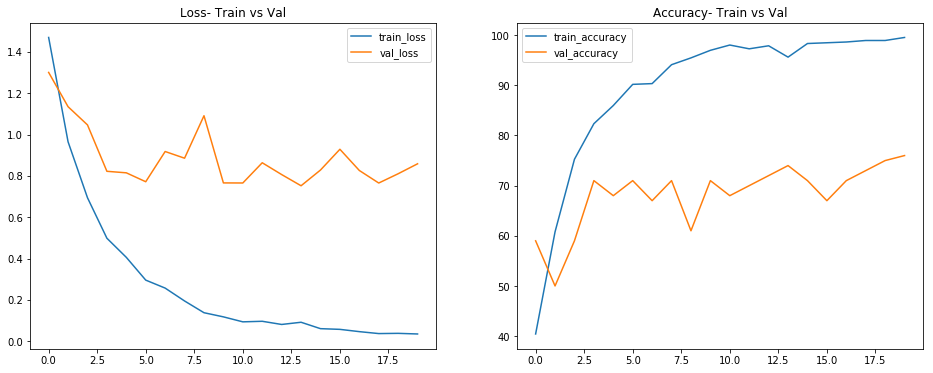

In [15]:
plot_training_details(history)

**MODEL 7A: MOBILENET WITH PARAMS AS TRAINABLE**

We can see above model is overfitting on training data. Now we will try to train mobilenet params also as part of this model and see if there is any improvemnt.

In [16]:
from keras.applications import MobileNet

In [26]:
def create_model7a():
    dropout = 0.3
    num_sample = 20
    image_height = 128
    image_width = 128
    channels = 3

    base_model=MobileNet(weights='imagenet',include_top=False, input_shape=(image_height, image_width, channels))
    for layer in base_model.layers:
        layer.trainable = True

    model7a = Sequential()
    model7a.add(TimeDistributed(base_model, input_shape= (num_sample, image_height, image_width, channels)))
    model7a.add(TimeDistributed(BatchNormalization()))
    model7a.add(TimeDistributed(MaxPooling2D((4, 4))))
    model7a.add(TimeDistributed(Flatten()))
    model7a.add(Dropout(dropout))

    model7a.add(GRU(64))
    model7a.add(Dropout(dropout))

    model7a.add(Dense(64,activation='relu'))
    model7a.add(Dropout(dropout))

    model7a.add(Dense(5, activation='softmax'))
    return model7a

In [27]:
model7a = create_model7a()
optimiser = optimizers.Adam() #write your optimizer
model7a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 20, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 20, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 1024)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
__________

In [28]:
batch_size = 16
set_steps_per_epoch(batch_size)
train_generator7a = generator(train_path, train_doc, batch_size, 20, 128, 128)
val_generator7a = generator(val_path, val_doc, batch_size, 20, 128, 128)
callbacks_list = create_call_backs()


history = model7a.fit_generator(train_generator7a, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator7a, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Steps per epoch: 42 and validation steps: 7 
Source path =  Project_data/val ; batch size = 16
range(5, 25)
Source path =  Project_data/train ; batch size = 16
Epoch 1/20
range(5, 25)
42/42 [==============================] - 77s 2s/step - loss: 1.4838 - categorical_accuracy: 0.3804 - val_loss: 1.1109 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-09-1208_40_30.439624/model-00001-1.49144-0.37406-1.11091-0.58000.h5
Epoch 2/20
42/42 [==============================] - 57s 1s/step - loss: 0.8678 - categorical_accuracy: 0.6390 - val_loss: 0.7453 - val_categorical_accuracy: 0.7500

Epoch 00002: saving model to model_init_2020-09-1208_40_30.439624/model-00002-0.86922-0.63801-0.74526-0.75000.h5
Epoch 3/20
42/42 [==============================] - 57s 1s/step - loss: 0.5702 - categorical_accuracy: 0.7734 - val_loss: 0.7278 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-09-1208_40_30.439624/model-00003-0.57380-0.77225-0.72782-0.69

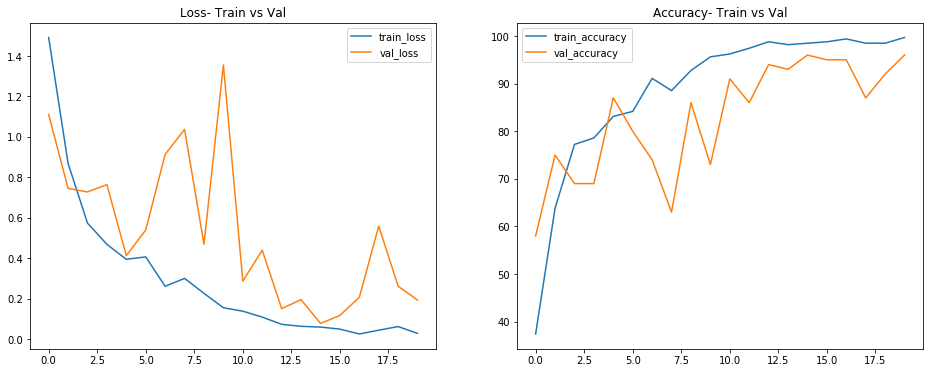

In [29]:
plot_training_details(history)

## FINAL MODEL SELECTION

Following are the promising models:
1.	Model2a, this is a CNN3D model.  Val Accuracy: 89 Train Accuracy: 93.66 
2.	Model6, GRU based model. Val Accuracy: 82 Train Accuracy: 84.77 
3.	Model7a, Transfer Learning with Mobilenet. Val Accuracy: 96 Train Accuracy: 98.52

**Considering the number of trainable parameters and size of the model, we will be selecting Model2a as final choice. The model file is “model-00020-0.20644-0.93665-0.40212-0.89000.h5” (Corresponding to Model2a)**

**IMPORTANT NOTE:** Only reason to rule out the Transfer learned model is its size. As per project statement there is no mention of upper bound on trainable params and model size. Since there is no quantitative statement provided as part of this case study, we are not able to suggest this model. If the size of 39.5 MB is acceptable, then we would like to go ahead with this model as final model. Corresponding saved file is \GestureRecognition_Group_Facilitator_SreenathS\SecondBest_TransferLearning_Model7a\ model-00020-0.02848-0.99698-0.19305-0.96000.h5
